<h1>How to get corner plots of the posterior with sbi</h1>
<div class="text">
    In this tutorial, I will show how to use the functions I created for the training of the NDE, in particular the Mixture Density Network (MDN), which is a probability distribution given by the sum of gaussians.
</div>

In [1]:
import sys
import os
import numpy as np
import torch
from copy import deepcopy
from sbi.utils import BoxUniform
from sbi.utils.user_input_checks import (
    check_sbi_inputs,
    process_prior
)
import matplotlib.pyplot as plt
import pandas as pd
sys.path.insert(1, os.path.abspath('../')) # Note that this line is useless with a regular pip installation of PyWST.
import pietrosbi_new as psbi

/obs/pguidi/anaconda3/envs/sbi_21cmfast_env/lib/python3.9/site-packages/py21cmfast/_cfg.py:57: UserWarning: Your configuration file is out of date. Updating...
  warnings.warn(
/obs/pguidi/anaconda3/envs/sbi_21cmfast_env/lib/python3.9/site-packages/py21cmfast/_cfg.py:41: UserWarning: Your configuration file is out of date. Updating...
  warnings.warn("Your configuration file is out of date. Updating...")


<h2>Importing the data of the statistics PS, S1, S2, PS3d</h2>

In [ ]:
bins_list = [6] 

# Select the path where the data are stored
path = ''

In [ ]:
# Create dictionaries where the number of bins is the key
l1l2_summary_S1_dict = {}
l1l2_summary_S2_dict = {}
l1l2_summary_PS_dict = {}
data_PS3d_dict = {}

# Similar dictionaries, but for the observed data
l1l2_summary_obs_S1_dict = {}
l1l2_summary_obs_S2_dict = {}
l1l2_summary_obs_PS_dict = {}
data_obs_PS3d_dict = {}

# For loop that imports the data for each value of number of bins
for bins in bins_list:
    full_path = os.path.join(path, f'bins_{bins}')
    
    l1l2_summary_PS_dict[bins] = np.load(os.path.join(full_path, 'l1l2_summary_PS.npy'))
    l1l2_summary_S1_dict[bins]  = np.load(os.path.join(full_path, 'l1l2_summary_S1.npy'))
    l1l2_summary_S2_dict[bins]  = np.load(os.path.join(full_path, 'l1l2_summary_S2.npy'))
    data_PS3d_dict[bins]  = np.load(os.path.join(full_path, 'data_PS3d.npy'))

    l1l2_summary_obs_PS_dict[bins] = np.load(os.path.join(full_path, 'l1l2_summary_obs_PS.npy'))
    l1l2_summary_obs_S1_dict[bins] = np.load(os.path.join(full_path, 'l1l2_summary_obs_S1.npy'))
    l1l2_summary_obs_S2_dict[bins] = np.load(os.path.join(full_path, 'l1l2_summary_obs_S2.npy'))
    data_obs_PS3d_dict[bins] = np.load(os.path.join(full_path, 'data_obs_PS3d.npy'))

param_list = torch.from_numpy(np.load(os.path.join(full_path, 'param_list.npy')))
param_true = torch.from_numpy(np.load(os.path.join(full_path, 'param_true.npy')))

In [ ]:
#####################
# FOR THE POSTERIOR #
#####################

# Rereate the prior you used when simulating the maps
lower = torch.tensor([20, 4.1])
upper = torch.tensor([40, 6])
prior = BoxUniform(low=lower, high=upper)
prior, num_parameters, prior_returns_numpy = process_prior(prior)


# Create an initialization of the class My_posterior()
# Afterwards you can call the functions to train the SBI and plot the posteriors
My_P = psbi.Inference(l1l2_summary_PS_dict = l1l2_summary_PS_dict, 
                         l1l2_summary_S1_dict = l1l2_summary_S1_dict,
                         l1l2_summary_S2_dict = l1l2_summary_S2_dict,
                         data_PS3d_dict = data_PS3d_dict,
                         param_list = param_list,
                         l1l2_summary_obs_PS_dict = l1l2_summary_obs_PS_dict,
                         l1l2_summary_obs_S1_dict = l1l2_summary_obs_S1_dict,
                         l1l2_summary_obs_S2_dict = l1l2_summary_obs_S2_dict,
                         data_obs_PS3d_dict = data_obs_PS3d_dict,
                         param_true = param_true,
                      prior = prior
                        )


2it [03:08, 94.18s/it]


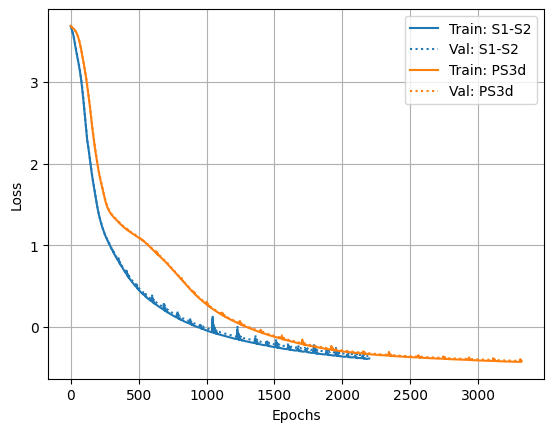

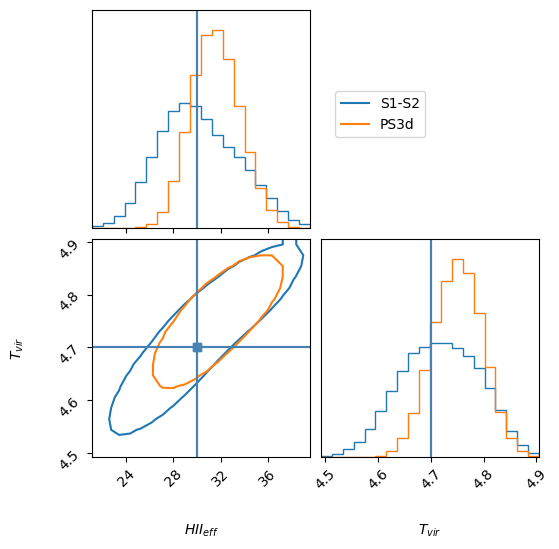

In [ ]:
# Each NDE is created with a dictionary
# - nde: the type of NDE
# - stats: the summary statistics used for the training of the NDE
# - size: number of simulations
# - bins: number of bins for the summary statistics
# - num_components: number of gaussian components in case of 'mdn'
# - hidden_features: number of hidden features for each layer of the NDE

nde_dict_1 = {'nde': 'mdn', 
              'stats': ['S1', 'S2'], 
              'size': 100000, 
              'bins': 6, 
              'num_components': 4,  
              'hidden_features': 15}

nde_dict_2 = {'nde': 'mdn', 
              'stats': ['PS3d'], 
              'size': 100000, 
              'bins': 6, 
              'num_components': 4, 
              'hidden_features': 20}


# List of NDEs
nde_list = [nde_dict_1, nde_dict_2]

# Calling posterior_corner_n if we want to plot the posterior of each NDE
density_estimator, samples = My_P.posterior_corner_n(nde_list, 
                                               lr = 6e-4, 
                                               epochs_max = 5000, 
                                               val_size = 0.2,
                                               patience = 20,
                                              loss_plot = True,
                                              corner_plot = True,
                                              corner_save = '', 
                                              loss_save = '')

100%|██████████| 2/2 [02:58<00:00, 89.48s/it]


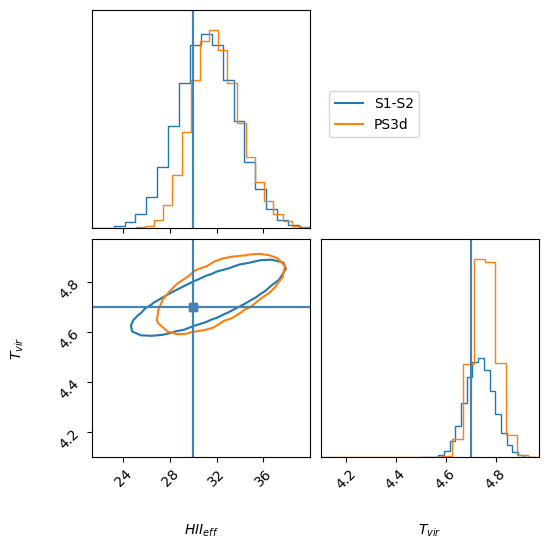

In [ ]:
nde_dict_S1S2 = {'nde': 'mdn', 
              'stats': ['S1', 'S2'], 
              'size': 100000, 
              'bins': 6, 
              'num_components': 1, 
              'built_NDE': 'custom', 
              'hidden_features': 20}


# Create the ensemble of NDEs.
# In this case 2 NDEs with the same architecture are used, 
# but the architecture can change inside an ensemble ('stats' should remain the same)
ensemble_S1S2 = [deepcopy(nde_dict_S1S2) for _ in range(2)]


nde_dict_PS3d = {'nde': 'mdn', 
              'stats': ['PS3d'], 
              'size': 100000, 
              'bins': 6, 
              'num_components': 4, 
              'built_NDE': 'custom', 
              'hidden_features': 20}

# Another ensemble
ensemble_PS3d = [deepcopy(nde_dict_PS3d) for _ in range(2)]

# List of ensembles
ensemble_list = [ensemble_S1S2, ensemble_PS3d]

# Training the ensembles and comparing the posteriors in one single corner plot
posterior_list = My_P.ensemble_n(ensemble_list, 
                            lr = 6e-4, 
                            epochs_max = 5000, 
                            val_size = 0.2, 
                            patience = 20, 
                            plot_ensembles = True, 
                            corner_save = '')

/mesopsl3/home/pguidi/files_github/pietrosbi_new/inference.py:577: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  likelihoods = torch.tensor(log_probability_samples).numpy()


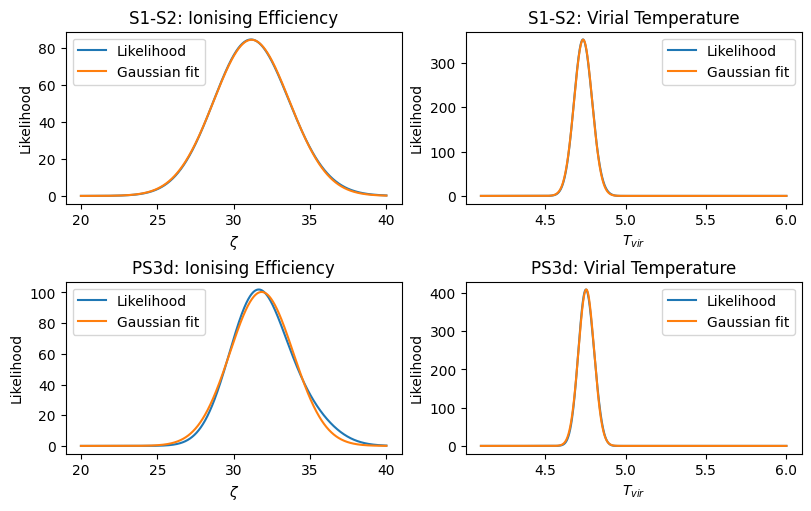

,S1-S2,PS3d
eff,0.040949,0.296296
Tvir,0.052073,-0.509679


In [ ]:
##############
# LIKELIHOOD #
##############

# Number of points for the likeilhood
n = 1000

# Creating a parameter grid
grid_eff = torch.linspace(lower[0], upper[0], n)
grid_Tvir = torch.linspace(lower[1], upper[1], n)
parameter_grid = torch.cartesian_prod(grid_eff, grid_Tvir)

# Creating an empty dictionary for the skewness. 
# The keys are the name of the statistics, and the values are dictionaries
skew_dict = {}
for ensemble in ensemble_list:
    stat = '-'.join(ensemble[0]['stats'])
    skew_dict[stat] = {}

rows = len(ensemble_list)

fig, ax = plt.subplots(rows,2, figsize = (8, 5), layout = 'constrained')

# For loop for each ensemble
for i,d in enumerate(posterior_list):
    # Calculating the likelihood
    like_eff, like_Tvir = My_P.calc_likelihood(ensemble_list[i][0], d, n, parameter_grid, ens = True)

    # Calculating the skewness
    skew_eff = My_P.calc_skew(grid_eff.clone().detach().numpy(), like_eff)
    skew_Tvir = My_P.calc_skew(grid_Tvir.clone().detach().numpy(), like_Tvir)
    skew_dict['-'.join(ensemble_list[i][0]['stats'])]['eff'] = skew_eff
    skew_dict['-'.join(ensemble_list[i][0]['stats'])]['Tvir'] = skew_Tvir

    # Finding the best gaussian fit
    mu_eff, std_eff, factor_eff = My_P.find_best_gaussian(grid_eff.clone().detach().numpy(), like_eff)
    mu_Tvir, std_Tvir, factor_Tvir = My_P.find_best_gaussian(grid_Tvir.clone().detach().numpy(), like_Tvir)
    
    # Calculating the y values of the best gaussian fit
    gauss_fit_eff = My_P.gaussian(grid_eff.clone().detach().numpy(), mu_eff, std_eff, factor_eff)
    gauss_fit_Tvir = My_P.gaussian(grid_Tvir.clone().detach().numpy(), mu_Tvir, std_Tvir, factor_Tvir)

 
    ax[i][0].plot(grid_eff, like_eff, label = 'Likelihood')
    ax[i][0].plot(grid_eff, gauss_fit_eff, label = 'Gaussian fit')
    ax[i][0].set_xlabel('$\zeta$')            
    ax[i][0].set_ylabel('Likelihood')
    ax[i][0].legend()
    ax[i][0].set_title('-'.join(ensemble_list[i][0]['stats']) + ': Ionising Efficiency')
    
    ax[i][1].plot(grid_Tvir, like_Tvir, label = 'Likelihood')
    ax[i][1].plot(grid_Tvir, gauss_fit_Tvir, label = 'Gaussian fit')
    ax[i][1].set_xlabel('$T_{vir}$')
    ax[i][1].set_ylabel('Likelihood')
    ax[i][1].legend()
    ax[i][1].set_title('-'.join(ensemble_list[i][0]['stats']) + ': Virial Temperature')


plt.show()

# Displaying a table with the values of skewness
df = pd.DataFrame.from_dict(skew_dict)
display(df)
